In [141]:
import pandas as pd
import useful_rdkit_utils as uru
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit import DataStructs
import seaborn as sns
from sklearn.model_selection import train_test_split
import scikit_posthocs as sp

Enable progress bars in Pandas

In [221]:
tqdm.pandas()

Read the SMILES for PDBBind with time splits from the DiffDock paper

In [251]:
diffdock_df = pd.read_csv("diffdock_pdb_SMILES.csv")

Examine the time splits

In [252]:
diffdock_df.split.value_counts()

ts_train    16379
ts_val        968
Name: split, dtype: int64

Add a molecule to the dataframe

In [224]:
diffdock_df['mol'] = diffdock_df.SMILES.progress_apply(Chem.MolFromSmiles)

  0%|          | 0/17347 [00:00<?, ?it/s]

[22:07:48] Explicit valence for atom # 24 C, 5, is greater than permitted
[22:07:48] Explicit valence for atom # 0 B, 5, is greater than permitted
[22:07:48] Explicit valence for atom # 10 C, 5, is greater than permitted
[22:07:48] Explicit valence for atom # 10 C, 5, is greater than permitted
[22:07:48] Explicit valence for atom # 11 S, 7, is greater than permitted
[22:07:48] Explicit valence for atom # 21 C, 5, is greater than permitted
[22:07:48] Explicit valence for atom # 21 C, 5, is greater than permitted
[22:07:49] Explicit valence for atom # 8 C, 5, is greater than permitted
[22:07:49] Explicit valence for atom # 13 C, 5, is greater than permitted
[22:07:49] Explicit valence for atom # 3 Br, 4, is greater than permitted
[22:07:49] Explicit valence for atom # 4 Cl, 2, is greater than permitted
[22:07:49] Explicit valence for atom # 12 C, 5, is greater than permitted
[22:07:49] Explicit valence for atom # 6 C, 5, is greater than permitted


How many molecules do we have?

In [226]:
num_original = len(diffdock_df)
num_original

17347

Drop the bad molecules

In [227]:
diffdock_df.dropna(subset="mol",inplace=True)

In [230]:
num_remaining = len(diffdock_df)
print(f"{num_original-num_remaining} molecules were dropped, leaving {num_remaining}")

13 molecules were dropped, leaving 17334


Drop duplicate molecules.  There are lots of copies of ATP etc.  

In [231]:
diffdock_df.drop_duplicates(subset="SMILES",inplace=True)

In [237]:
len(diffdock_df)

13925

In [238]:
diffdock_df.split.value_counts()

ts_train    13131
ts_val        794
Name: split, dtype: int64

Add a fingerprint. 

In [239]:
diffdock_df['fp'] = diffdock_df.mol.progress_apply(uru.mol2morgan_fp)

  0%|          | 0/13925 [00:00<?, ?it/s]

Time split into training and test_sets

In [240]:
time_split_train = diffdock_df.query("split == 'ts_train'")
time_split_test = diffdock_df.query("split == 'ts_val'")

A function to find the most similar molecule in dbase to query

In [241]:
def get_most_similar(query,dbase):
    sim_list = []
    for fp in query.fp.values:
        max_sim = max(DataStructs.BulkTanimotoSimilarity(fp, dbase.fp.values))
        sim_list.append(max_sim)
    return sim_list

Calculate the similarity of test set molecules to the training set

In [242]:
time_split_sim_list = get_most_similar(time_split_test, time_split_train)

Put the time split similarities into a dataframe

In [243]:
time_split_df = pd.DataFrame(time_split_sim_list,columns=["Max_Tanimoto"])
time_split_df['split'] = "time_split"
time_split_df['method'] = "time"

Get the size of the test set

In [244]:
num_time_split_test = len(time_split_test)
num_time_split_test

794

Get stats over 10 cross validation folds

In [246]:
df_list = [time_split_df]
for i in tqdm(range(0,10)):
    train, test = train_test_split(diffdock_df, test_size=num_time_split_test)
    random_sim_list = get_most_similar(test, train)
    random_split_df = pd.DataFrame(random_sim_list,columns=["Max_Tanimoto"])
    random_split_df['split'] = f"rand_{i}"
    random_split_df['method'] = "random"
    df_list.append(random_split_df)
combo_df = pd.concat(df_list)

  0%|          | 0/10 [00:00<?, ?it/s]

In [247]:
sns.set(rc={'figure.figsize': (10, 5)})
sns.set_style('whitegrid')
sns.set_context('notebook')

Plot similarities as boxplots 

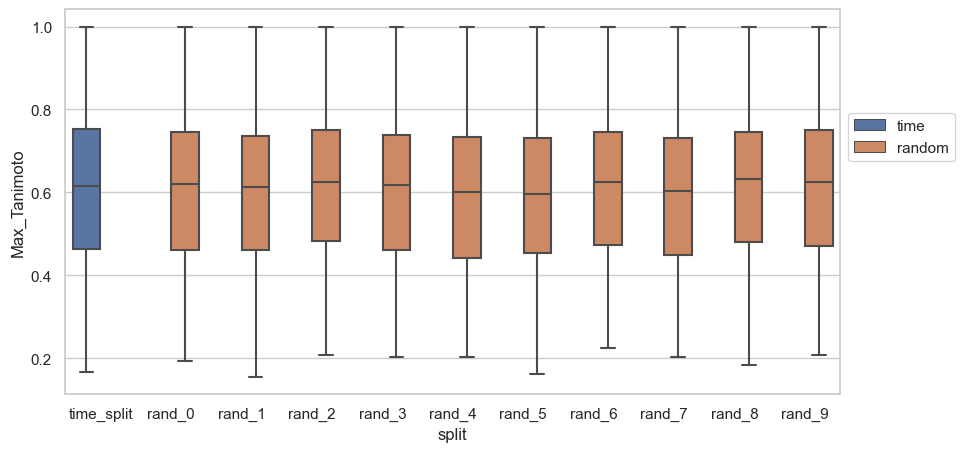

In [248]:
ax = sns.boxplot(x="split",y="Max_Tanimoto",hue="method",data=combo_df)
ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1);

Plot similarities as an ECDF.

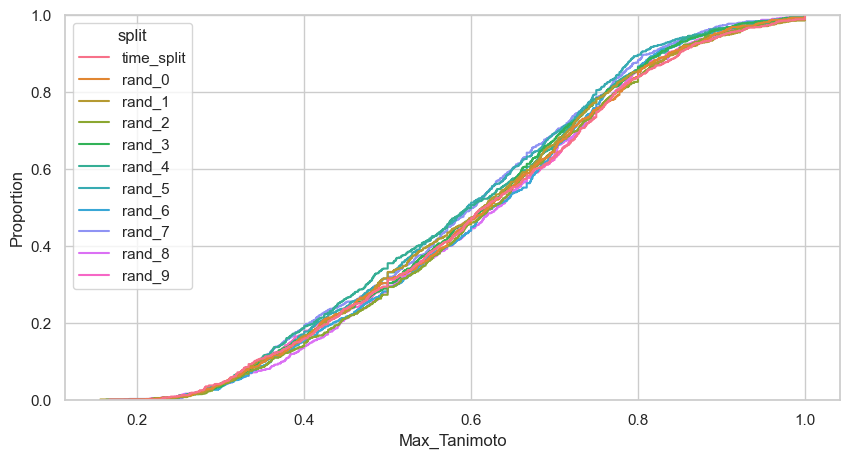

In [249]:
sns.ecdfplot(x="Max_Tanimoto",hue="split",data=combo_df);

Is there a difference between the disribution for the time split and the distributions for the 10 random splits? **No**

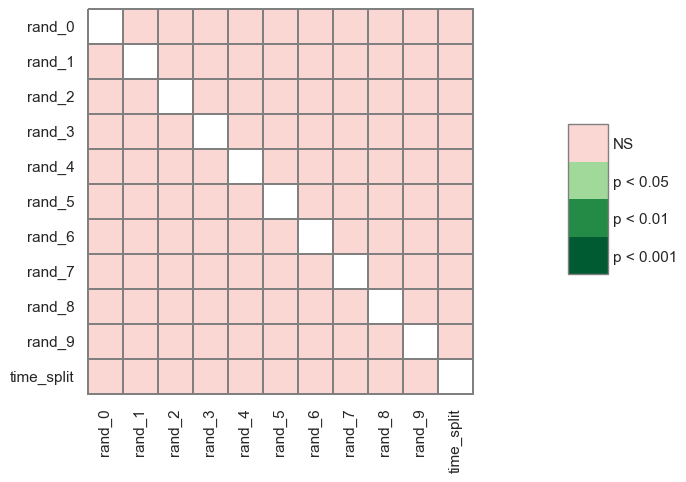

In [250]:
pc = sp.posthoc_mannwhitney(combo_df,val_col="Max_Tanimoto",group_col="split",p_adjust='holm')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
_ = sp.sign_plot(pc, **heatmap_args)